In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH21-1-SingleAGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-1-SingleAGENT


# Single Agent 

인터넷 검색 결과를 토대로 코드를 실행하는 에이전트 

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

## 1. Tool

In [4]:
# 인터넷 검색 도구 
web_search = TavilySearchResults(max_results=3)

In [5]:
# 파이썬 코드 실행 도구 
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. chart labels should be written in English.
    This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [6]:
# 도구 목록 정의
tools=[web_search, python_repl]
tool_node = ToolNode(tools)

In [7]:
# 모델 정의 및 도구 연결 
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

## 2. Graph

In [8]:
# 에이전트 상태 정의 
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
# 에이전트 노드 정의 : LLM 호출 
def agent(state: State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [10]:
# 도구 사용 여부에 따라 흐름을 분기하는 조건 노드 
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [11]:
workflow = StateGraph(State)

workflow.add_node("agent", agent)
workflow.add_node("tool", tool_node)
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tool",
        "end": END,
    },
)

workflow.add_edge("tool", "agent")

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory, interrupt_before=["tool"])

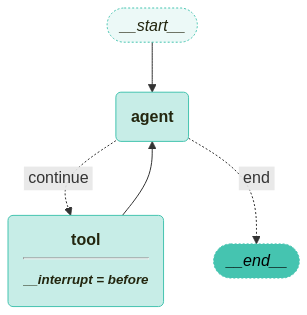

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 3. 실행

In [13]:
initial_input = {"messages": [HumanMessage(content="미국의 최근 5개년(~2023) GDP 차트를 그려 주세요.")]}
thread = {"configurable": {"thread_id": "001"}}

### 첫번째 실행 

- 에이전트가 사용자 요청 분석 (initial_input)
- 도구(web_search) 호출 결정 -> interrupt 발생 
- 이 때 LangGraph이 멈추는데, 결과를 아직 실행하지는 않았음 

In [ ]:
async for chunk in graph.astream(initial_input, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'agent'
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ix2KCnCn5khMKqvZf9t9rriE', 'function': {'arguments': '{"query":"United States GDP data for the last 5 years (2019-2023)"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 167, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f8e44b87-bc13-4c18-af86-984f6e732f8c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'United States GDP data for the last 5 years (2019-2023)'}, 'id': 'call_ix2KCnCn5khMKqvZf9t9rriE', 'type': 'tool_call'}], 

- Receiving update from node: 'agent' 
    - 에이전트 노드(agent)가 실행되었고
    - 이 노드에서 LLM이 사용자 요청을 받아 인터넷 검색 도구를 호출하기로 판단

- Receiving update from node: '__interrupt__'
    - graph = workflow.compile(checkpointer=memory, interrupt_before=["tool"])
        - 툴 노드를 실행하기 전에 일시 정지 
        - 에이전트가 도구를 사용하고자 할 때 멈춰서 상황을 점검 (디버깅 포인트) 

### 두번째 실행 

- input : None, 같은 thread 
- 이제 web_search 결과를 반환하면 다시 에이전트로 돌아감 
- 에이전트는 결과를 바탕으로 차트 코드를 생성하려고 함 -> python_repl 호출 

In [ ]:
# 추가 실행 : 도구 호출 결과만 이어서 처리 
async for chunk in graph.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'tool'
{'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/united-states/gdp", "content": "The Gross Domestic Product (GDP) in the United States was worth 27360.94 billion US dollars in 2023, according to official data from the World Bank. The GDP value of the United States represents 25.95 percent of the world economy. source: World Bank [...] United States GDP\\nThe gross domestic product (GDP) measures of national income and output for a given country\'s economy. The gross domestic product (GDP) is equal to the total expenditures for all final goods and services produced within the country in a stipulated period of time.\\n|  | Actual | Previous | Highest | Lowest | Dates | Unit | Frequency |  |\\n| --- | --- | --- | --- | --- | --- | --- | --- | --- |\\n|  | 27360.94 | 25744.11 | 27360.94 | 541.99 | 1960 - 2023 | USD Billion | Yearly | [...] Interest Rate\\nInflation Rate\\nUnemployment Rate\\nGDP Growth\\nGDP per Capita\\nCurrent A

### 세번째 실행 

- input : None, 같은 thread 
- python_repl 도구 실행 (그래프 그리기) 
- 에이전트가 결과 출력하고 종료 처리 

Python REPL can execute arbitrary code. Use with caution.


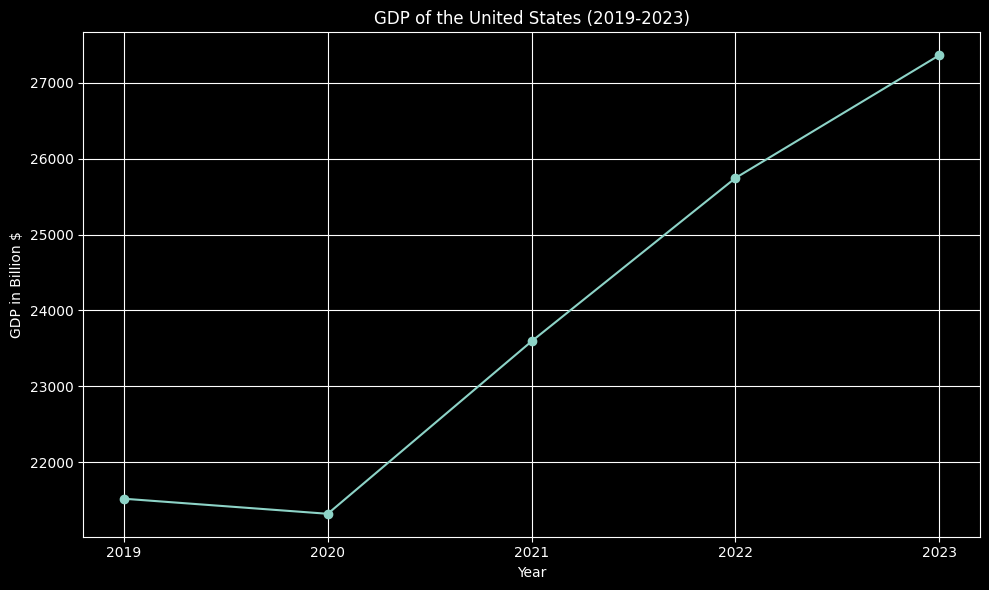

Receiving update from node: 'tool'
{'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\ngdp_data = {\n    'Year': [2019, 2020, 2021, 2022, 2023],\n    'GDP (Billion $)': [21521.40, 21322.95, 23594.03, 25744.11, 27360.94]\n}\n\ndf = pd.DataFrame(gdp_data)\n\nplt.figure(figsize=(10, 6))\nplt.plot(df['Year'], df['GDP (Billion $)'], marker='o')\nplt.title('GDP of the United States (2019-2023)')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion $')\nplt.xticks(df['Year'])\nplt.grid()\nplt.tight_layout()\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', id='57ff66a2-2924-42b6-ae67-4c35234f0925', tool_call_id='call_fQaaucle2i0L3htvn1jny3GQ')]}



Receiving update from node: 'agent'
{'messages': [AIMessage(content='Here is the chart showing the GDP of the United States from 2019 to 2023:\n\n![GDP of the United States (2019-2023)](attachment://gdp_chart.png)\n\n- 

In [ ]:
# 추가 실행 : 입력 없이 반복 처리 
async for chunk in graph.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

--------
** End of Documents **